# Predicting Future Sales

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import warnings
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

Packages

In [2]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
scipy 1.3.1
lightgbm 2.3.0
seaborn 0.9.0


## Functions

We import the functions we have developed for this assignment.

In [3]:
from funs import downcast_dtypes, rmse,  get_feature_matrix, clip20, clip40

## Load raw data

Let's load the data from the hard drive first.

In [4]:
sales = pd.read_csv('data/sales_train.csv.gz')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv.gz')

## Exploratory Data Analaysis (EDA)

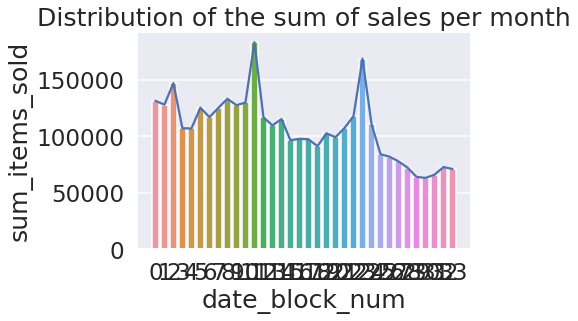

In [5]:
sns.set_context("talk", font_scale=1.4)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
del sales_month

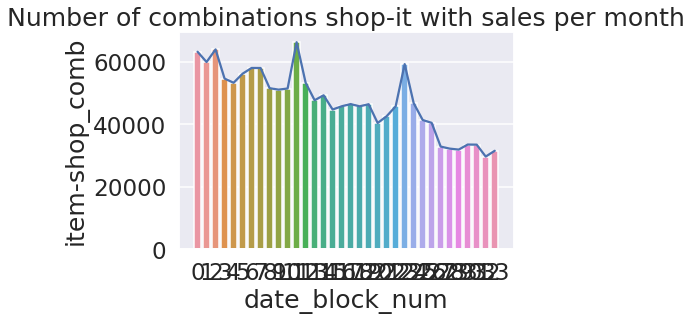

In [6]:
comb_shop_item = pd.DataFrame(sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations shop-it with sales per month')
del comb_shop_item

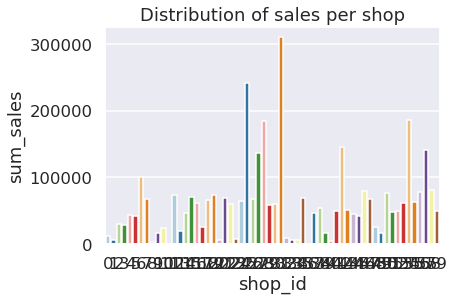

In [7]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

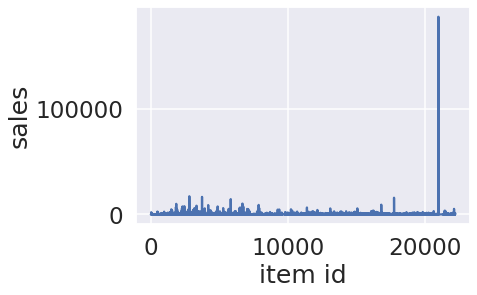

In [8]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

There is one item with an anomaly number of sales. The item id is:

In [9]:
anomaly_item = sales_item_id.item_cnt_day.argmax()
anomaly_item

20949

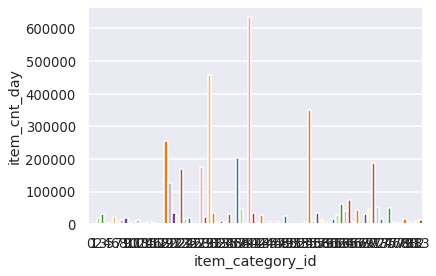

In [10]:
#fig, ax = plt.subplots()
sns.set_context("talk", font_scale=0.8)
sales_item_cat = sales.merge(items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=sales_item_cat.reset_index(), 
            palette='Paired'
           );
del sales_item_cat

## Data Leakage

Only the 41% of the all combinations item-shop that we have data appears in the test set. <p>
We model in order to take advantage of this data leakage as much as possible.

In [11]:
tuples_df = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(tuples_df.isin(tuples_test).sum()/len(tuples_df),2)*100)+'%')

42.0%


## Get a feature matrix

The set of ids that appear in the test set, once there is a historical sale, will be saved every subsequent month (including zero values). This strategy improves our model because it can infer the predictions about items not for sales in the test month (months with zero sales in a row). Moreover, we create the input for the submission with the date_block_num=34

In [12]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = sales[sales.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_for_modelling, test, items, list_lags, date_block_threshold)

In [13]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


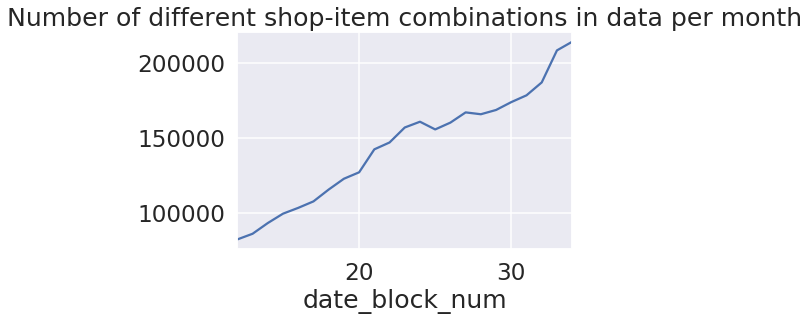

In [15]:
sns.set_context("talk", font_scale=1.4)
plt.title('Number of different shop-item combinations in data per month')
all_data.groupby('date_block_num').size().plot();

## Advanced Feature Engineering 
mean / variance encoding for category-id last month

In [16]:
mean_enc_item_cat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']
all_data = pd.merge(all_data, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
del mean_enc_item_cat
all_data = downcast_dtypes(all_data)

# Train/dev/test split strategy

We create a input dataframe for making the competition submission (date_block_num=34).<p>The target is zero because we do not have the information sales for this month. We only get the model input from the table.

In [17]:
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
sub_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459


Our validation set is associated with the months 22, 31, 32, 33.

In [18]:
dates = all_data['date_block_num']
boolean_test = (dates.isin([22,31,32,33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

We save the data for the model grid search (differente notebook)

In [19]:
# X_train.to_parquet('data/X_train.parquet')
# X_val.to_parquet('data/X_val.parquet')
# np.save(arr=y_train, file='data/y_train.npy')
# np.save(arr=y_val, file='data/y_val.npy')

In [20]:
print('X_train shape is ' + str(X_train.shape))
print('X_val shape is ' + str(X_val.shape))

X_train shape is (2389620, 14)
X_val shape is (720954, 14)


In [21]:
print(f'Cross-validation is the {round(X_val.shape[0]/X_train.shape[0],2)*100} %' )

Cross-validation is the 30.0 %


In [22]:
tuples_validation_submission = pd.Series(list(X_val[['item_id', 'shop_id']][dates_val==33].itertuples(index=False, name=None)))
print(f'The {round(tuples_test.isin(tuples_validation_submission).sum()/len(tuples_test),2)*100} % of the item_id-shop_id are in the cv set ') 

The 93.0 % of the item_id-shop_id are in the cv set 


# Modelling with stacking

### Test meta-features

In [23]:
lgb = pickle.load(open('models/best_lgb.sav', 'rb'))

In [24]:
pred_lgb_val = lgb.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.838416
Val RMSE for lgb is 0.805686


In [25]:
sub_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3324769,45,18454,34,0.0,0.0,0.0,1.0,2.0,683.0,0.0,1.0,624.0,0.0,3.0,653.0,55,0.171227,0.275635
3324770,45,16188,34,0.0,0.0,0.0,0.0,1.0,683.0,0.0,3.0,624.0,0.0,0.0,0.0,64,0.187426,0.221231
3324771,45,15757,34,0.0,0.0,0.0,0.0,5.0,683.0,0.0,3.0,624.0,0.0,4.0,653.0,55,0.171227,0.275635
3324772,45,19648,34,0.0,0.0,0.0,0.0,2.0,683.0,0.0,3.0,624.0,0.0,7.0,653.0,40,0.128883,0.235513


### LGB model

In [26]:
predict = clip20(lgb.predict(sub_data.drop(to_drop_cols, axis=1)))


In [27]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = predict
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('submission/submission.csv',index=False)

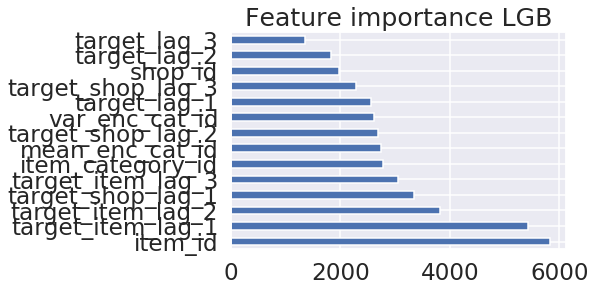

In [28]:
feat_importances = pd.Series(lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

In [29]:
model = RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1)

In [30]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [31]:
pred = model.predict(X_val)

In [32]:
rmse(clip20(y_val), clip20(pred))

1.035982511342477

In [36]:
model_1 = XGBRegressor(learning_rate=0.05, max_depth=10)

In [37]:
model_1.fit(X_train, y_train)

[00:39:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [38]:
pred_1 = model_1.predict(X_val)
rmse(clip20(y_val), clip20(pred_1))

0.9910659